In [28]:
try:
    import skmultilearn
    import datasets
    import faiss
    print("Libraries are already installed.")
except ImportError:
    print("Libraries not found. Installing now...")
    %pip install scikit-multilearn datasets faiss-gpu

Libraries are already installed.


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import os
from huggingface_hub import notebook_login, login
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split
from google.colab import userdata
from sklearn.preprocessing import MultiLabelBinarizer
from datasets import Dataset, DatasetDict, load_from_disk
from collections import defaultdict
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer
import torch
import faiss
from joblib import Parallel, delayed
from transformers import AutoTokenizer, AutoModel
import torch.multiprocessing as mp

In [31]:
def load_csv(file_path):
    """Load the CSV file into a DataFrame."""
    return pd.read_csv(file_path, on_bad_lines='skip', delimiter=',', encoding='utf-8', nrows=12000)

def list_fields(df: pd.DataFrame):
    return df.columns.tolist()

def list_labels(df: pd.DataFrame, coluna_labels: str):
    return df[coluna_labels].explode().unique().tolist()

def list_qtd_no_labels(df: pd.DataFrame, coluna_labels: str):
  return  df[coluna_labels].isnull().sum()

def list_qtd_with_labels(df: pd.DataFrame, coluna_labels: str):
  return  df[coluna_labels].notnull().sum()

def list_per_label(df: pd.DataFrame, coluna_labels: str):
  return df[coluna_labels].value_counts()


In [32]:
file_path = '/content/drive/MyDrive/emotion_f.csv'

df = load_csv(file_path)

print(list_fields(df))
print(list_labels(df, 'Emotion'))
print(list_qtd_with_labels(df,'Emotion'))
print(list_qtd_no_labels(df,'Emotion'))
list_per_label(df,'Emotion')


['Unnamed: 0', 'text', 'Emotion']
['hate', 'neutral', 'anger', 'love', 'worry', nan, 'relief', 'happiness', 'fun', 'empty', 'enthusiasm', 'sadness', 'surprise', 'boredom']
11940
60


,count
Emotion,
neutral,9770
love,456
happiness,364
relief,272
hate,217
anger,211
sadness,173
fun,140
enthusiasm,132


In [33]:
df['with_label'] = df['Emotion'].notnull()

df[['Emotion', 'with_label']].head()

,Emotion,with_label
0,hate,True
1,neutral,True
2,neutral,True
3,anger,True
4,neutral,True


In [34]:
df['Combined_Text'] = df[['text', 'Emotion']].fillna('').agg(' '.join, axis=1)

df[['text', 'Emotion', 'Combined_Text']].head()

,text,Emotion,Combined_Text
0,i seriously hate one subject to death but now ...,hate,i seriously hate one subject to death but now ...
1,im so full of life i feel appalled,neutral,im so full of life i feel appalled neutral
2,i sit here to write i start to dig out my feel...,neutral,i sit here to write i start to dig out my feel...
3,ive been really angry with r and i feel like a...,anger,ive been really angry with r and i feel like a...
4,i feel suspicious if there is no one outside l...,neutral,i feel suspicious if there is no one outside l...


In [35]:
duplicate_records = df.duplicated(subset=['Combined_Text']).sum()

df = df.drop_duplicates(subset=['Combined_Text'])

duplicate_records

107

<ipython-input-36-9fa9b7183858>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Word_Count'] = df['Combined_Text'].apply(lambda x: len(x.split()))


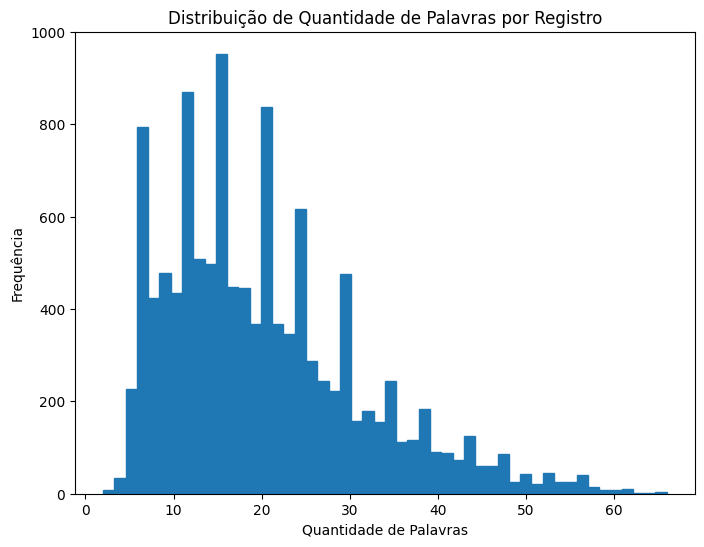

In [36]:

df['Word_Count'] = df['Combined_Text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 6))
df['Word_Count'].plot(kind='hist', bins=50, edgecolor="C0")
plt.title('Distribuição de Quantidade de Palavras por Registro')
plt.xlabel('Quantidade de Palavras')
plt.ylabel('Frequência')
plt.show()


In [37]:
# Clean Emotion: Remove whitespaces and NaNs, convert to consistent format
df['Emotion'] = df['Emotion'].fillna("").str.strip().str.lower()

# Extract unique class names and clean them
labels_class_names = df['Emotion'].unique()
all_labels = [x for x in labels_class_names if x]
all_labels

['hate',
 'neutral',
 'anger',
 'love',
 'worry',
 'relief',
 'happiness',
 'fun',
 'empty',
 'enthusiasm',
 'sadness',
 'surprise',
 'boredom']

In [38]:
df["split"] = "unlabeled"
mask = df["with_label"].apply(lambda x: x) == True
df.loc[mask, "split"] = "labeled"
df["split"].value_counts().to_frame()

,count
split,
labeled,11833
unlabeled,60


In [39]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["hate", "anger"], ["neutral"]])

array([[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

In [40]:
def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["Emotion"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels,
                                                           test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

In [41]:
# Transform Class Names for the main dataframe
df_clean = df[["Combined_Text", "Emotion", "split"]].reset_index(drop=True).copy()
df_clean["Emotion"] = df_clean["Emotion"].apply(lambda x: [x] if x else [])

# Separate labeled and unlabeled data
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["Combined_Text", "Emotion"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["Combined_Text", "Emotion"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [42]:
ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

In [43]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["Emotion"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # Split off samples necessary to fill the gap to the next split size
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

# Add full dataset as last slice
train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [44]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])


Target split sizes:
[8, 16, 32, 64, 128, 5917]
Actual split sizes:
[7, 14, 28, 59, 121, 5917]


In [45]:
#hide_output
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["Emotion"])
    return batch

ds = ds.map(prepare_labels, batched=True)

Map:   0%|          | 0/5917 [00:00<?, ? examples/s]

Map:   0%|          | 0/2958 [00:00<?, ? examples/s]

Map:   0%|          | 0/2958 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

In [46]:
macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [47]:
for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["Combined_Text"])
    X_test_counts = count_vect.transform(ds["test"]["Combined_Text"])
    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # Store metrics
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

In [48]:
def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model, output_csv="all_model_scores.csv"):
    """
    Plot micro and macro F1 scores for different sample sizes and save the data as a CSV file.

    Args:
        micro_scores (dict): Dictionary containing micro F1 scores for each run.
        macro_scores (dict): Dictionary containing macro F1 scores for each run.
        sample_sizes (list): List of sample sizes.
        current_model (str): Name of the current model.
        output_csv (str): Filename to save the CSV data.
    """
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    # Collect data for saving to CSV
    all_data = []

    for run in micro_scores.keys():
        # Create and append data for each model and sample size
        for i, sample_size in enumerate(sample_sizes):
            all_data.append({
                'Model': run,
                'Sample Size': sample_size,
                'Micro F1': micro_scores[run][i],
                'Macro F1': macro_scores[run][i]
            })

        # Plotting the metrics
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run, linestyle="dashed")

    # Save the data to CSV
    df = pd.DataFrame(all_data)
    df.to_csv(output_csv, index=False)
    print(f"Data saved to {output_csv}")

    # Plot formatting
    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()


Data saved to all_model_scores.csv


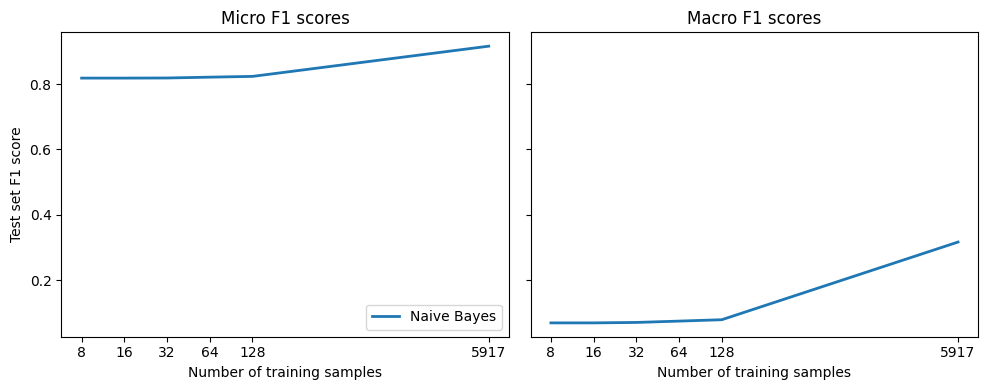

In [49]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")


In [50]:
import torch
from transformers import AutoTokenizer, AutoModel

model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

# Mean pooling function to get the final embeddings
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of output contains the embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

# Embed text function
def embed_text(examples):
    # Initialize model within the function to avoid CUDA reinitialization issues
    model = AutoModel.from_pretrained(model_ckpt).to('cuda')  # Move to GPU inside the function
    # Tokenize and move tensors to GPU
    inputs = tokenizer(examples["Combined_Text"], padding=True, truncation=True, max_length=128, return_tensors="pt")
    inputs = {key: value.to('cuda') for key, value in inputs.items()}
    # Perform inference and mean pooling without gradient calculation
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}  # Move to CPU to save memory

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [51]:
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)

Map:   0%|          | 0/5917 [00:00<?, ? examples/s]

Map:   0%|          | 0/2958 [00:00<?, ? examples/s]

Map:   0%|          | 0/2958 [00:00<?, ? examples/s]

In [52]:
def get_sample_preds(sample, m):
    return (np.sum(sample["label_ids"], axis=0) >= m).astype(int)


def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
    max_k = min(len(ds_train), max_k)
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k):
        for m in range(1, k + 1):
            _, samples = ds_train.get_nearest_examples_batch("embedding",
                                                             valid_queries, k=k)
            y_pred = np.array([get_sample_preds(s, m) for s in samples])
            clf_report = classification_report(valid_labels, y_pred,
                target_names=mlb.classes_, zero_division=0, output_dict=True)
            perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
            perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
    return perf_micro, perf_macro

In [53]:
embs_train.add_faiss_index("embedding")
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)

  0%|          | 0/6 [00:00<?, ?it/s]

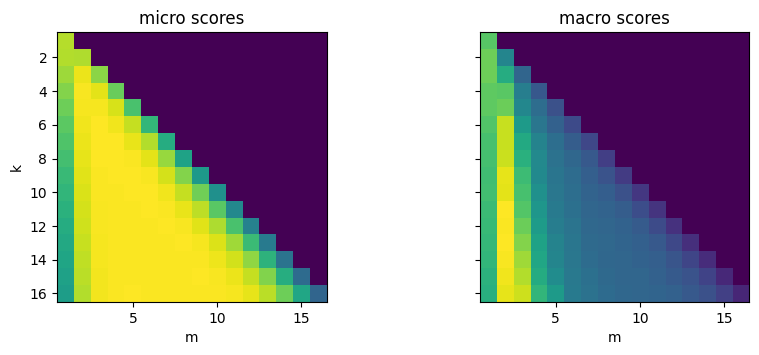

In [54]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0, ax1]:
    ax.set_xlim([0.5, 17 - 0.5])
    ax.set_ylim([17 - 0.5, 0.5])
    ax.set_xlabel("m")
plt.show()

In [55]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f"Best k: {k}, best m: {m}")

Best k: 6, best m: 3


In [ ]:
# hide_output
embs_train.drop_index("embedding")
test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embedding"], dtype=np.float32)

for train_slice in train_slices:
    # Create a FAISS index from training slice
    embs_train_tmp = embs_train.select(train_slice)
    embs_train_tmp.add_faiss_index("embedding")
    # Get best k, m values with validation set
    perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
    k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
    # Get predictions on test set
    _, samples = embs_train_tmp.get_nearest_examples_batch("embedding",
                                                           test_queries,
                                                           k=int(k))
    y_pred = np.array([get_sample_preds(s, m) for s in samples])
    # Evaluate predictions
    clf_report = classification_report(test_labels, y_pred,
        target_names=mlb.classes_, zero_division=0, output_dict=True,)
    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")